# PyLTR deltaBTimeSeries (Parallel) Demonstration
------------------------------

In [1]:
# this SHOULD work inside JupyterLab if the Python environment is correct
#%matplotlib widget

# this does NOT work inside JupyterLab, but DOES in a Notebook (less insecure)
%matplotlib notebook

# this should work anywhere
# %matplotlib inline

In [2]:
# import built-in Python libraries
import warnings

# import common Python packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import ipyparallel

# import home-built packages
import pyLTR

In [3]:
# set up Cartopy to plot nice maps
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

scale = '50m'
coast = cfeature.NaturalEarthFeature(
        category='physical',
        name='coastline',
        scale=scale,
        edgecolor='k',
        facecolor='none')
land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land', 
        scale=scale,
        edgecolor='face',
        facecolor=cfeature.COLORS['land'])
# land = cfeature.LAND
ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale=scale,
        facecolor=np.sqrt(cfeature.COLORS['water']))
rivers = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale=scale,
        facecolor=cfeature.COLORS['water'],
        edgecolor='face')
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale=scale,
        facecolor=cfeature.COLORS['water'],
        edgecolor='face')
states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale=scale,
        facecolor='none',
        edgecolor='k')
countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale=scale,
        facecolor='none',
        edgecolor='k')

def symlog(x):
    """Returns the symmetric log10 value, allowing for negatives"""
    if np.any(np.abs(x) <= 1):
        print("Warning: log values between -1 and 1 flip the sign.")
    return np.sign(x) * np.log10(np.abs(x))

# Create the colormap RGB scale
# cmap_name = 'BinaryRedGreen'
cm_RedGreen = mpl.colors.LinearSegmentedColormap.from_list('BinaryRedGreen',
                                                           [(1, 0, 0), (0, 1, 0)], N=2)

def log_scale_vectors(x, y, scale=np.log10):
    mag = np.sqrt(x*x + y*y)
    angle = np.arctan2(y, x)
    
    mag_scaled = scale(mag)
    mag_scaled[mag_scaled < 0] = 0
    return (mag_scaled*np.cos(angle), mag_scaled*np.sin(angle))

## Runtime Configuration

In [4]:
# set configuration parameters

# folder with outputs
# NOTE: If using a relative path, this path must be wrt where the IPython
#       kernel is running. This may be different for a given cell in this
#       notebook and the kernel used by IPyParallel if the user is not
#       careful. It is probably better to just use absolute paths.
#
# path = '/glade/scratch/jrigler/LTR/2015SP/'
path = '/Users/erigler/Devel/Python/pyLTR/examples/data/models/2015StP/'

# prefix for output files
#run = '2015Mar17'
run = '2015SP'

# start time and endtime for processing
t0 = datetime.datetime(2015,3,17,6,0,0)
t1 = datetime.datetime(2015,3,17,6,9,0)

# output folder (this must be relative to path)
outPath = "./"

In [5]:
# Define observatory list 
# (these are real locations for synthetic observatories)

obs = {}

obs['BOU'] = {'name':'Boulder',             'geoLatitude':40.14, 'geoLongitude':254.76}
obs['BRW'] = {'name':'Barrow',              'geoLatitude':71.32, 'geoLongitude':203.38}
obs['BSL'] = {'name':'Stennis Space Center','geoLatitude':30.35, 'geoLongitude':270.37}

obs['CMO'] = {'name':'College',             'geoLatitude':64.87, 'geoLongitude':212.14}
obs['DED'] = {'name':'Deadhorse',           'geoLatitude':70.36, 'geoLongitude':211.21}
obs['FRD'] = {'name':'Fredricksburg',       'geoLatitude':38.20, 'geoLongitude':282.63}

obs['FRN'] = {'name':'Fresno',              'geoLatitude':37.09, 'geoLongitude':240.28}
obs['GUA'] = {'name':'Guam',                'geoLatitude':13.59, 'geoLongitude':144.87}
obs['HON'] = {'name':'Honolulu',            'geoLatitude':21.32, 'geoLongitude':202.00}

obs['NEW'] = {'name':'Newport',             'geoLatitude':48.27, 'geoLongitude':242.88}
obs['SHU'] = {'name':'Shumagin',            'geoLatitude':55.35, 'geoLongitude':199.54}
obs['SIT'] = {'name':'Sitka',               'geoLatitude':57.06, 'geoLongitude':224.67}

obs['SJG'] = {'name':'San Juan',            'geoLatitude':18.11, 'geoLongitude':293.85}
obs['TUC'] = {'name':'Tucson',              'geoLatitude':32.17, 'geoLongitude':249.27}


obs['BLC'] = {'name':'Baker Lake',          'geoLatitude':64.30, 'geoLongitude':264.00}
obs['BRD'] = {'name':'Brandon',             'geoLatitude':49.60, 'geoLongitude':262.90}
obs['HAD'] = {'name':'Hartland',            'geoLatitude':51.00, 'geoLongitude':355.00}

obs['HER'] = {'name':'Hermanus',            'geoLatitude':-34.40, 'geoLongitude':19.20}
obs['IQA'] = {'name':'Iqaluit',             'geoLatitude':63.80, 'geoLongitude':291.50}
obs['KAK'] = {'name':'Kakioka',             'geoLatitude':36.20, 'geoLongitude':140.20}

obs['MEA'] = {'name':'Meanook',             'geoLatitude':54.60, 'geoLongitude':246.70}
obs['OTT'] = {'name':'Ottowa',              'geoLatitude':45.40, 'geoLongitude':284.50}
obs['RES'] = {'name':'Resolute Bay',        'geoLatitude':74.70, 'geoLongitude':265.10}

obs['STJ'] = {'name':'Saint John\'s',       'geoLatitude':47.60, 'geoLongitude':307.30}
obs['VIC'] = {'name':'Victoria',            'geoLatitude':48.60, 'geoLongitude':236.60}
obs['YKC'] = {'name':'Yellow Knife',        'geoLatitude':62.40, 'geoLongitude':245.50}

# create list of lists of observatory coordinates to pass to detlaBTimeSeries.py
obsList = [[elem[1]['geoLongitude']*np.pi/180,
           (90-elem[1]['geoLatitude'])*np.pi/180,
           6378000,
           elem[0]]
           for elem in obs.items()]

In [6]:
# define list of *North American* gridded locations 
# at which to calculate ground deltaB
lons, lats = np.meshgrid(np.linspace(-170,-30,71), np.linspace(80,20,31) )
gridList = [[lons.flat[i] * np.pi/180,
             (90 - lats.flat[i]) * np.pi/180,
             6378000]
             for i in range(lons.size)]

In [7]:
# define list of *Northern hemisphere* gridded locations 
# at which to calculate ground deltaB
lons, lats = np.meshgrid(np.mod(np.linspace(0,360,181)[:-1], 360), np.linspace(90,0,46) )
gridList = [[lons.flat[i] * np.pi/180,
             (90 - lats.flat[i]) * np.pi/180,
             6378000]
             for i in range(lons.size)]

## (IPy)Parallel Processing

Break up the time series into time chunks, then use IPyParallel to run deltaBTimeSeries in an "embarassingly parallel" mode.

>
> Note  1: Be sure you have an adequate number of processors available. Since this is a
>          Jupyter notebook, there is a good chance you are running it on an NCAR
>          "interactive" queue. To request dedicated cores on a single node, start things
>          with:
>
> `qinteractive -X -l select=1:ncpus=8 -l walltime=06:00:00`
>
>
> Note  2: To use ipyparallel, we must set up parallel engines *before* starting IPython/
>          Jupyter Notebook; also, since it is not easy to guarantee two logins on the same
>          NCAR supercomputer node, these engines must be run in the background of the shell:
>
> `ipcluster start -n 4 > ipyparallel_YYYYMMDD.log 2>&1 &`
>
> (with modern (2019) Jupyter Notebooks, and with ipyparallel package available, it
>  seems like one can do this via the `IPython Clusters` tab on Notebook's dashboard)
>


 ***Generate deltaBTimeSeries at obsList locations***

In [29]:
try:
    # initialization ipyparallel client and create "direct view"
    client = ipyparallel.Client()
    dview = client[:]

    # generate a list of datetimes to process
    tAll = [t0 + datetime.timedelta(minutes=delta_min) 
            for delta_min in range(int((t1 - t0).total_seconds() // 60 + 1))]

    # Break up time interval into chunks for parallel processing
    nprocs = len(dview)
    t0s, t1s = np.transpose([[arr[0], arr[-1]]
                             for arr in np.array_split(tAll, nprocs)])

    print("Invoking %d parallel processes"%(len(dview)))

    # construct list of argument dictionaries
    args = [{'path':path, 
             'run':run,
             't0':t0s[i],
             't1':t1s[i],
             'obsList':obsList,
             'geoGrid':True,
             'mix':True,
             'tie':True,
             'lfm':True,
             'mix_bs_mx':True,
             'tie_bs_mx':True,
             'ignoreBinary':False,
             'binaryType':'pkl',
             'outDirName':outPath + '/obs'}
            for i in range(len(t0s))]

    # Use deltaBTimeSeries to generate synthetic geomagnetic observations
    def mappable_dBextract(kwargs):
        """mappable wrapper to unpack kwargs and pass to dBextract"""
        return pyLTR.Tools.deltaBTimeSeries.extractQuantities(**kwargs)

    # Use ipyparallel %magic function to import pyLTR into the engines
    %px import pyLTR

    # run in parallel
    results = dview.map_sync(mappable_dBextract, args)

except ipyparallel.error.TimeoutError:
    warnings.warn("\nNo IPython parallel computing clusters enabled...nothing processed!")

Invoking 2 parallel processes


 ***Generate deltaBTimeSeries at gridList locations***

In [30]:
try:
    # initialization ipyparallel client and create "direct view"
    client = ipyparallel.Client()
    dview = client[:]
    
    # generate a list of datetimes to process
    tAll = [t0 + datetime.timedelta(minutes=delta_min) 
            for delta_min in range(int((t1 - t0).total_seconds() // 60 + 1))]

    # Break up time interval into chunks for parallel processing
    nprocs = len(dview)
    t0s, t1s = np.transpose([[arr[0], arr[-1]]
                             for arr in np.array_split(tAll, nprocs)])
        
    print("Invoking %d parallel processes"%(len(dview)))
   
    # construct list of argument dictionaries
    args = [{'path':path, 
             'run':run,
             't0':t0s[i],
             't1':t1s[i],
             'obsList':gridList,
             'geoGrid':True,
             'mix':True,
             'tie':True,
             'lfm':True,
             'mix_bs_mx':False,
             'tie_bs_mx':False,
             'ignoreBinary':False,
             'binaryType':'pkl',
             'outDirName':outPath + '/grid'}
            for i in range(len(t0s))]

    # Use deltaBTimeSeries to generate synthetic geomagnetic observations
    def mappable_dBextract(kwargs):
        """mappable wrapper to unpack kwargs and pass to dBextract"""
        return pyLTR.Tools.deltaBTimeSeries.extractQuantities(**kwargs)

    # Use ipyparallel %magic function to import pyLTR into the engines
    %px import pyLTR

    # run in parallel
    results = dview.map_sync(mappable_dBextract, args)

except ipyparallel.error.TimeoutError:
    warnings.warn("\nNo IPython parallel computing clusters enabled...nothing processed!")

Invoking 2 parallel processes


# Serial Processing

Ideally, this block would simply collate the IPyParallel results chronologically, which should be a fairly trivial operation. If the IPyParallel block failed for any reason, deltaBTimeSeries will be run in serial.

In [36]:
# run deltaBTimeSeries on obsList again to read in all the pkl files generated
# previously and collate them chronologically
dBTSextract = pyLTR.Tools.deltaBTimeSeries.extractQuantities
dBobs = dBTSextract(**{
    'path':path, 
    'run':run,
    't0':t0,
    't1':t1,
    'obsList':obsList,
    'geoGrid':True,
    'mix':True,
    'tie':True,
    'lfm':True,
    'mix_bs_mx':False,
    'tie_bs_mx':False,
    'ignoreBinary':True,
    'binaryType':'pkl',
    'outDirName':outPath + '/obs'
})

Extracting quantities for 10 time steps.
Likely not a run from terminal so no progress bar

Starting main loop

MIX

Initializing Northern MIX DALECS
   ...ionospheric currents
Initializing  23040  type1 Bostrom loops
Initializing  23040  type2 Bostrom loops
   ...field-aligned currents
Initializing  23040  type1 Bostrom loops
Initializing  23040  type2 Bostrom loops
done after 80.267801 seconds

Initializing Southern MIX DALECS
   ...ionospheric currents
Initializing  23040  type1 Bostrom loops
Initializing  23040  type2 Bostrom loops
   ...field-aligned currents
Initializing  23040  type1 Bostrom loops
Initializing  23040  type2 Bostrom loops
done after 79.678957 seconds

Scale northern DALECS and integrate Biot-Savart
599040
589680
10904400
11035440
...done after 5.517320 seconds

Scale southern DALECS and integrate Biot-Savart
599040
599040
11054160
11035440
...done after 5.522807 seconds

TIEGCM

Initializing TIEGCM DALECS
   ...ionospheric currents
Initializing  7760  type1 Bostr

In [36]:
print(axs[0].shape)

(2,)


<IPython.core.display.Javascript object>


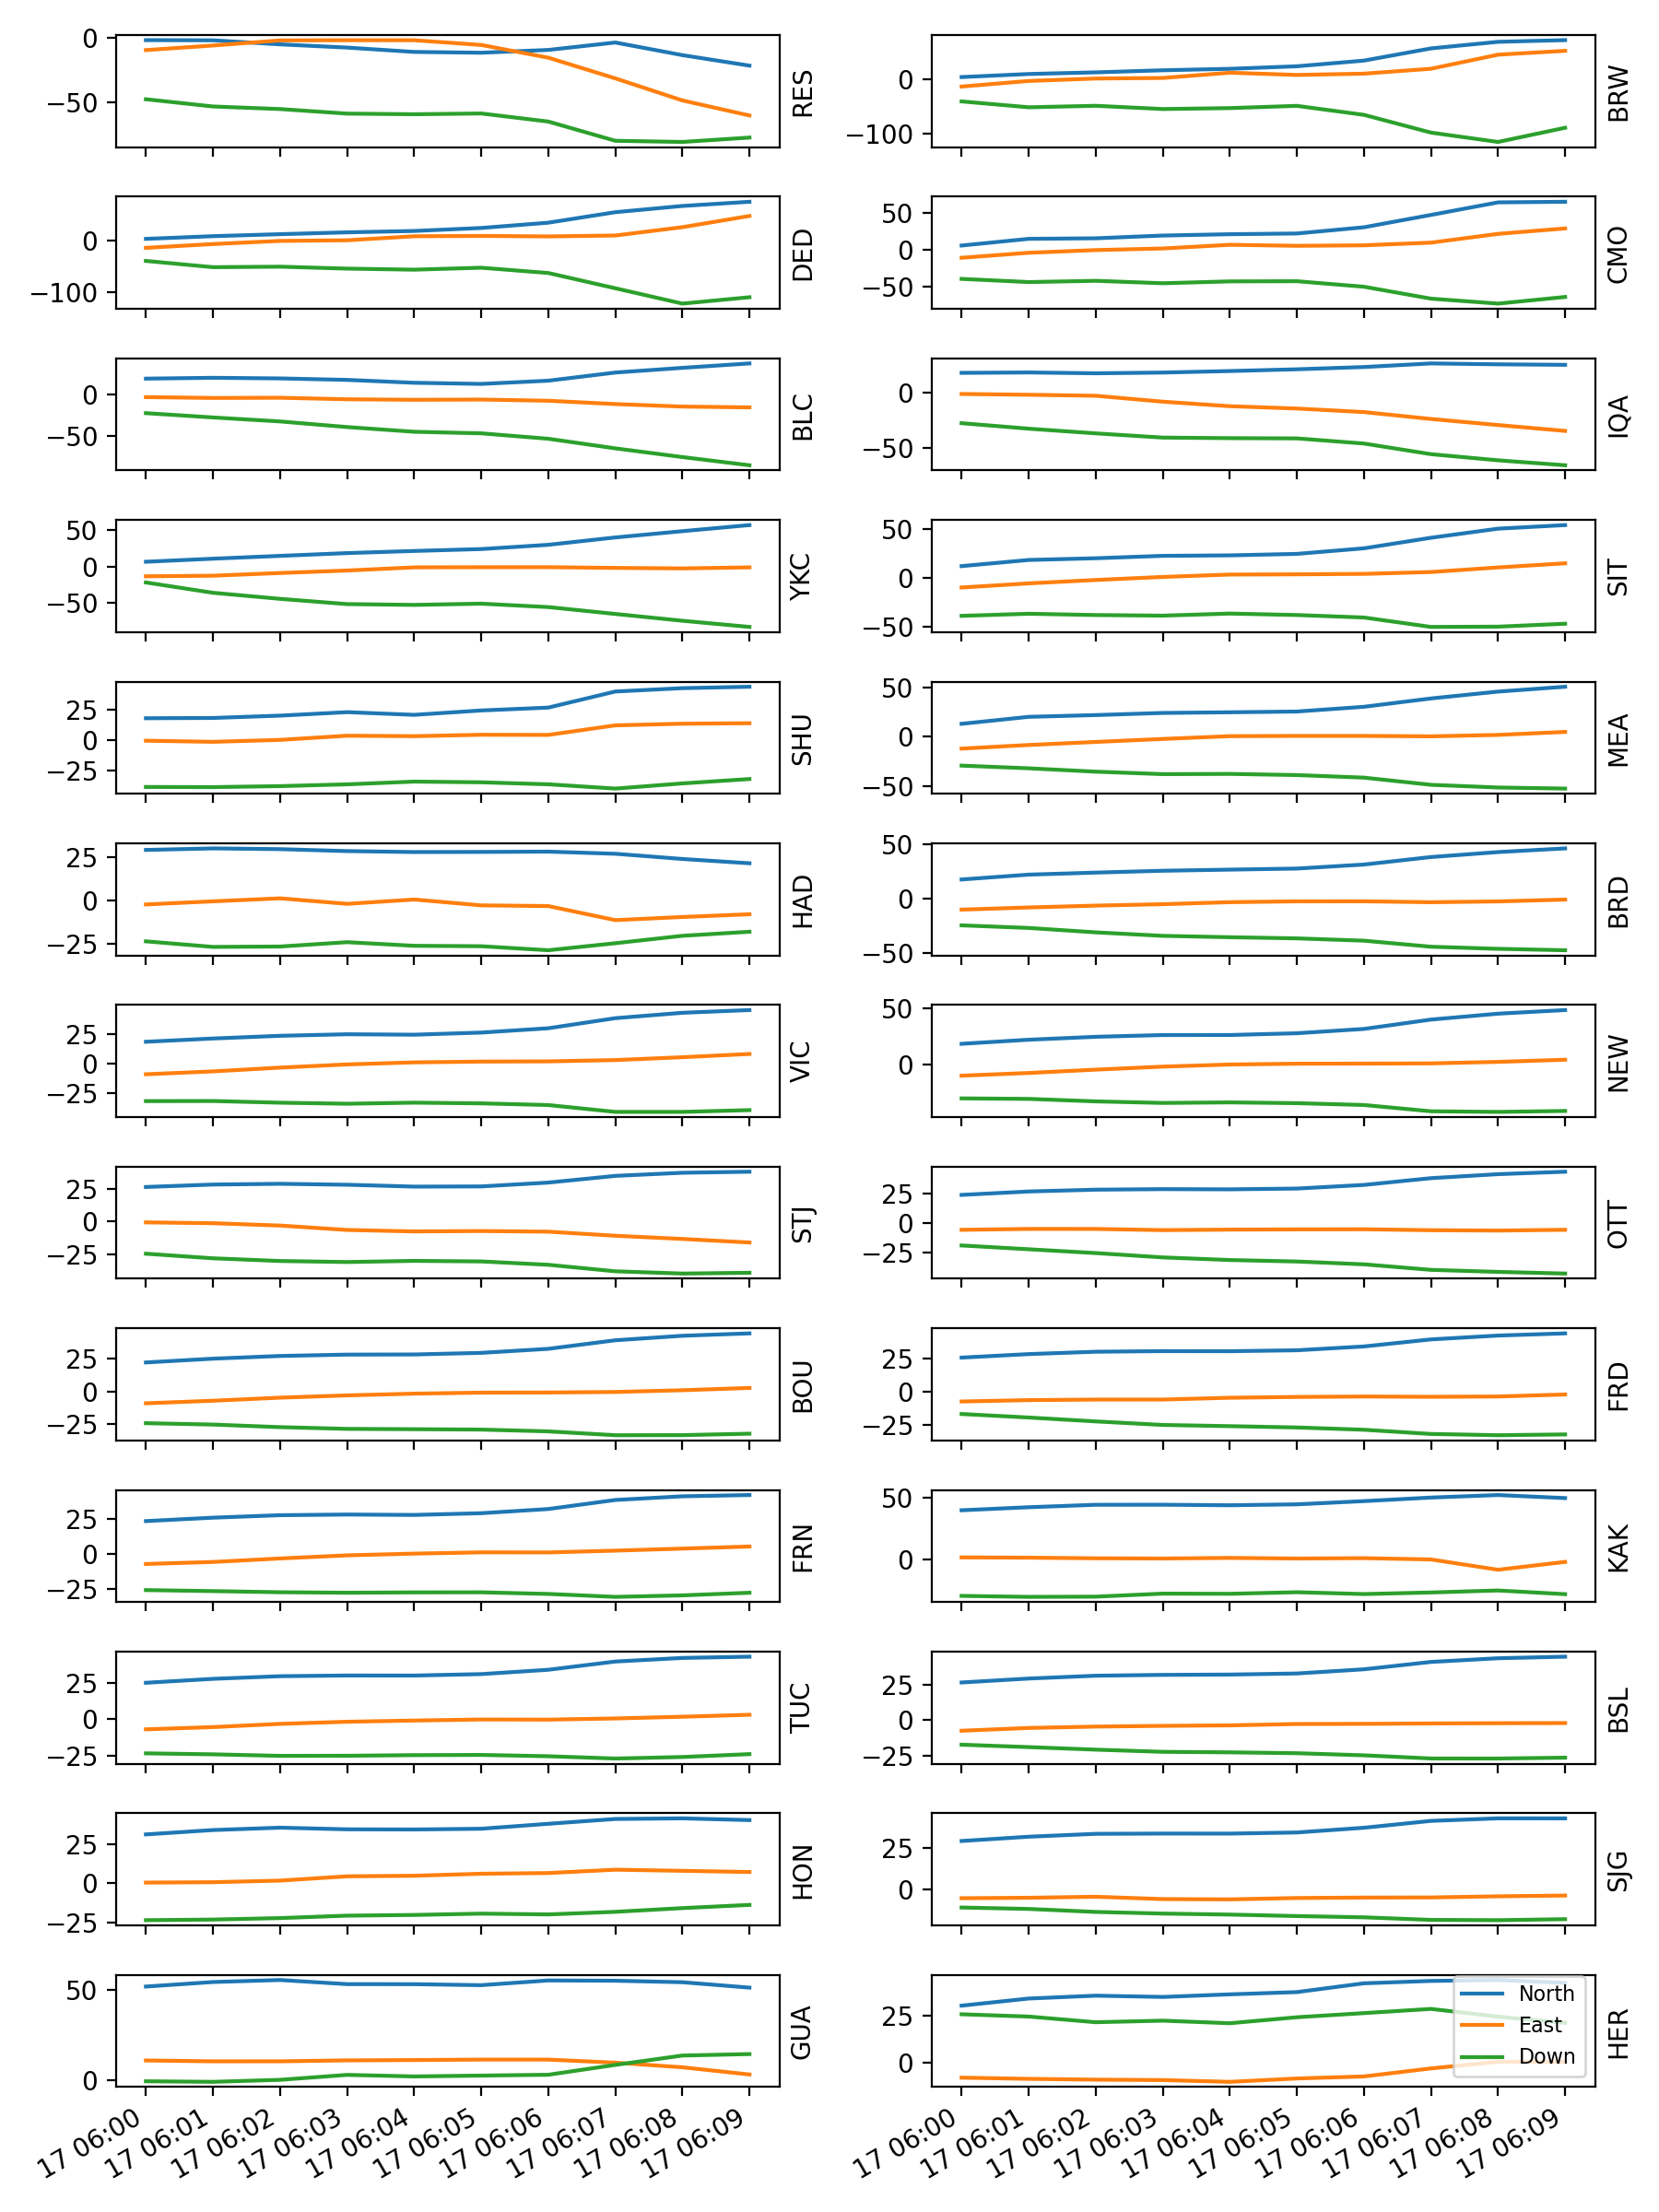

In [28]:
# Plot the time series
fig, axs = plt.subplots(len(dBobs) // 2, 2, figsize=(9,12))

# plt.figure(figsize=(9,12))
for i,obs in enumerate(dBobs):
    axs.flat[i].plot(obs['dBTot']['datetime']['data'],
                obs['dBTot']['North']['data'])
    axs.flat[i].plot(obs['dBTot']['datetime']['data'],
                obs['dBTot']['East']['data'])
    axs.flat[i].plot(obs['dBTot']['datetime']['data'],
                obs['dBTot']['Down']['data'])
    axs.flat[i].set_ylabel(obs['dBTot']['obs']['name'])
    axs.flat[i].yaxis.set_label_position('right')
    axs.flat[i].set_xticklabels('')
    
    if i+1 == len(dBobs) or i+1 == len(dBobs)-1:
        axs.flat[i].clear()
        axs.flat[i].plot(obs['dBTot']['datetime']['data'],
                    obs['dBTot']['North']['data'])
        axs.flat[i].plot(obs['dBTot']['datetime']['data'],
                    obs['dBTot']['East']['data'])
        axs.flat[i].plot(obs['dBTot']['datetime']['data'],
                    obs['dBTot']['Down']['data'])
        axs.flat[i].set_ylabel(obs['dBTot']['obs']['name'])
        axs.flat[i].yaxis.set_label_position('right')
        
    if i+1 == len(dBobs):
        axs.flat[i].legend(('North','East','Down'), loc='lower right', prop={'size': 8})

fig.autofmt_xdate()
fig.set_tight_layout(True)

In [41]:
# run deltaBTimeSeries on gridList again to read in all the pkl files generated
# previously and collate them chronologically
dBTSextract = pyLTR.Tools.deltaBTimeSeries.extractQuantities
dBgrid = dBTSextract(**{
    'path':path, 
    'run':run,
    't0':t0,
    't1':t1,
    'obsList':gridList,
    'geoGrid':True,
    'mix':True,
    'tie':True,
    'lfm':True,
    'mix_bs_mx':False,
    'tie_bs_mx':False,
    'ignoreBinary':False,
    'binaryType':'pkl',
    'outDirName':outPath + '/grid'
})

Extracting quantities for 10 time steps.
Likely not a run from terminal so no progress bar

Starting main loop


<IPython.core.display.Javascript object>


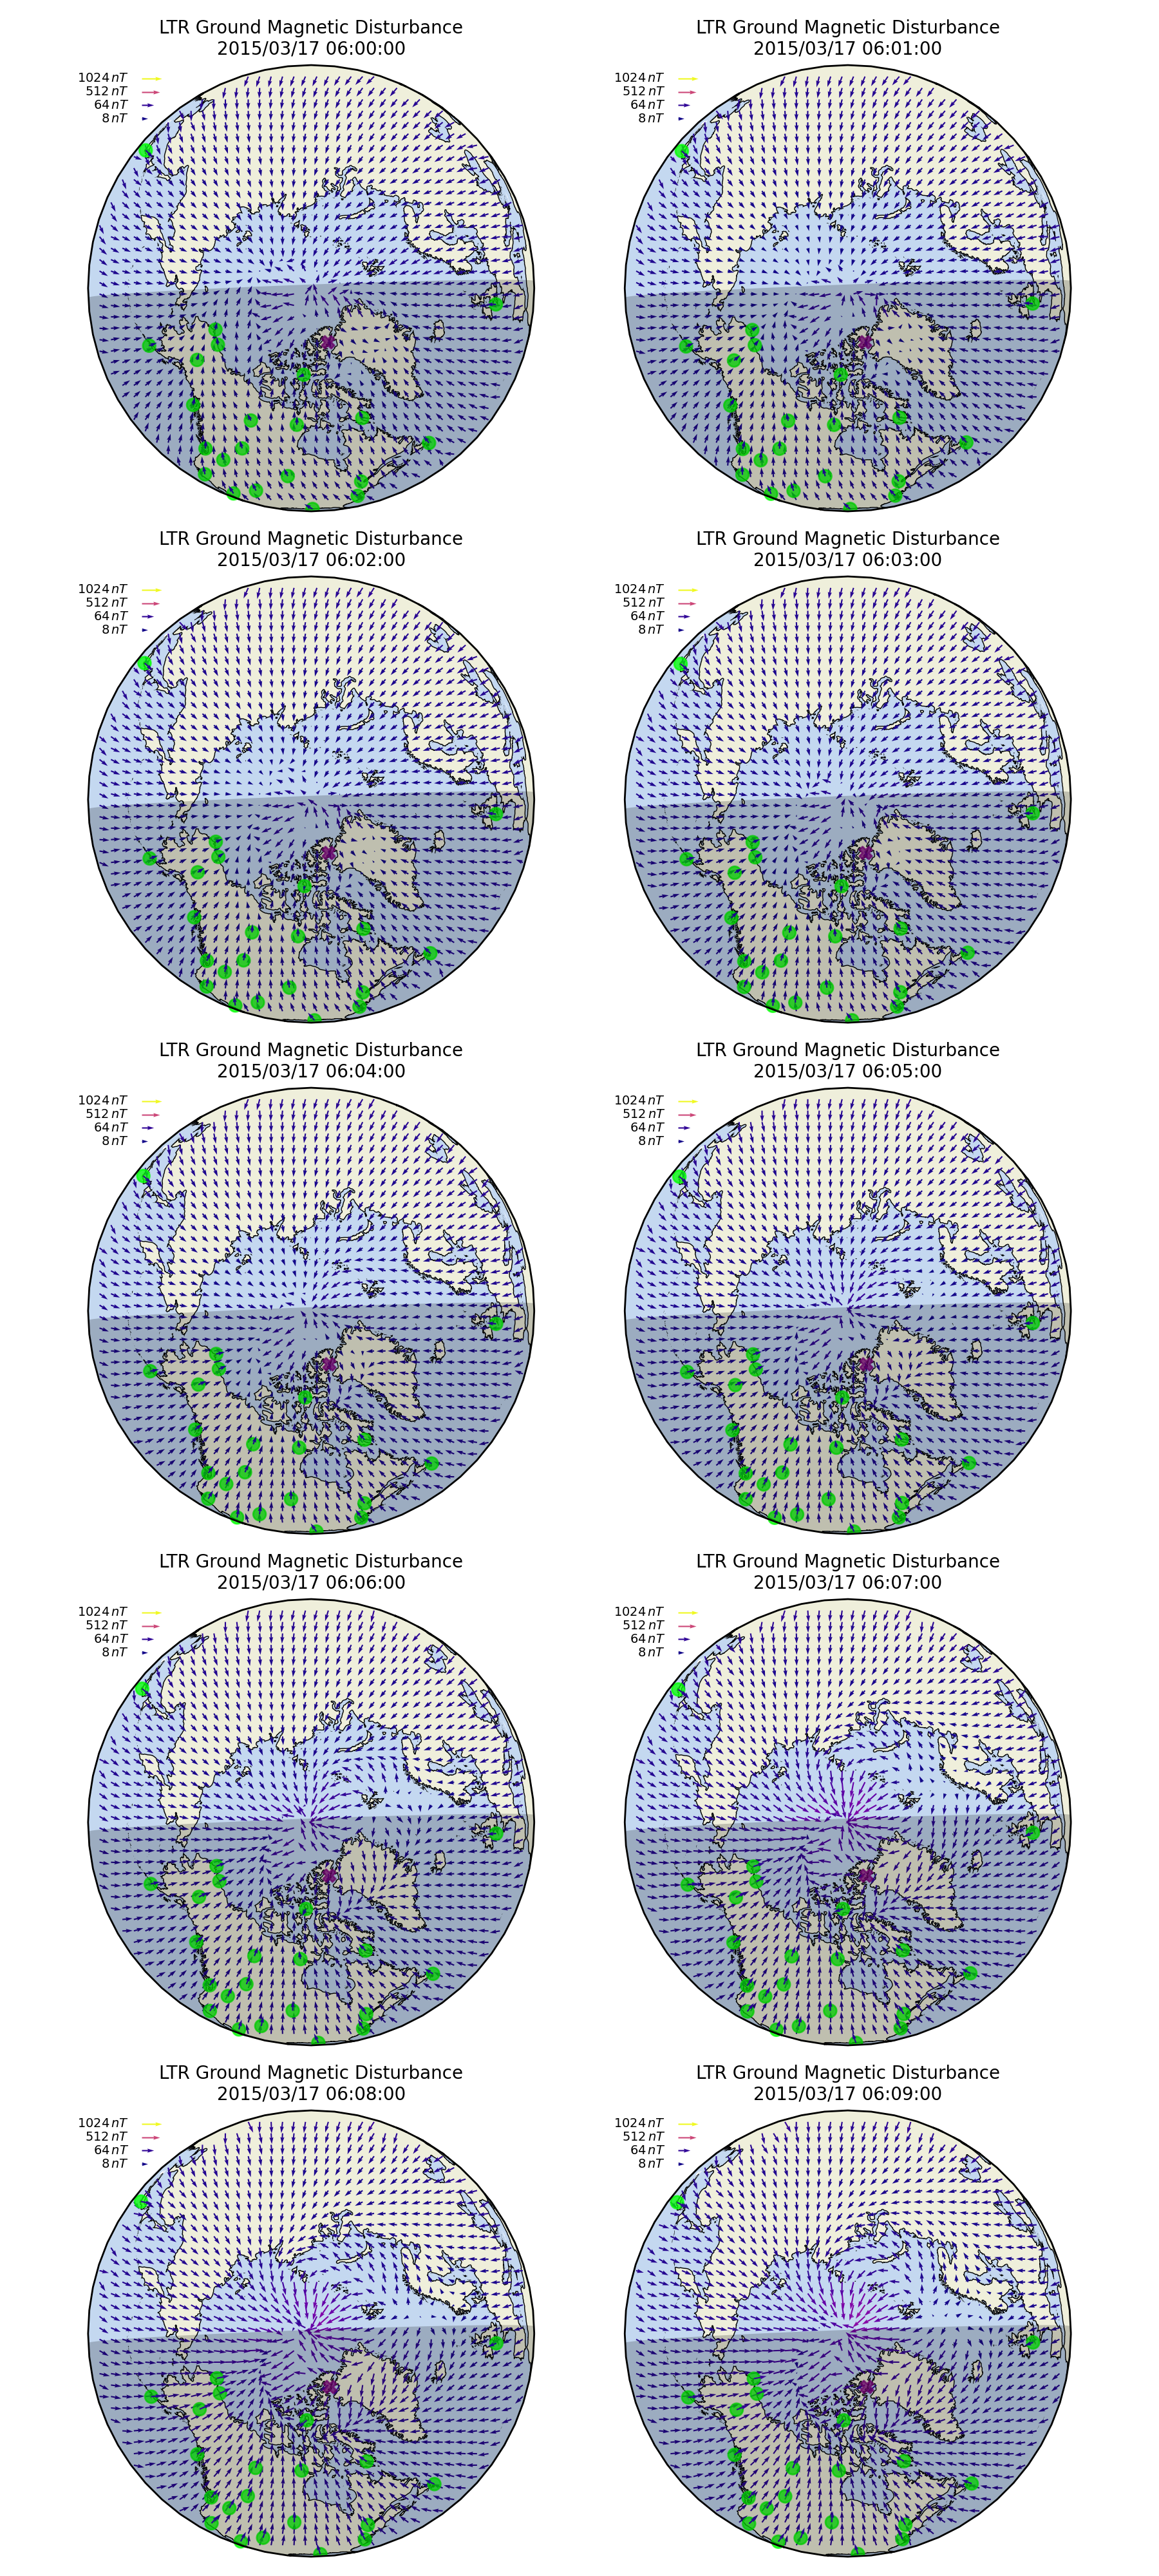

In [52]:
# plot some snapshots of gridded deltaB

from cartopy.feature.nightshade import Nightshade

r = 5 # rows 
c = 2 # columns
n = len(dBobs[0]['dBTot']['datetime']['data'])
step = int(np.ceil(n / (r * c)))
fig = plt.figure(figsize=(9, r*4), tight_layout=True)
axs = [] # empty list to hold axes created inside loop

# loop over time step index
for t in range(n)[0::step]:

    # 
    # configure map
    #
    utc = dBobs[0]['dBTot']['datetime']['data'][t]
    utc_seconds = (utc - utc.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    utc_angle = (utc_seconds/86400. * 360)
    
    central_lat = 90
    central_lon = -utc_angle # forces sun/noon to top
    # projection = ccrs.Orthographic(central_latitude=central_lat, central_longitude=central_lon)
    projection = ccrs.NearsidePerspective(central_latitude=central_lat, 
                                          central_longitude=central_lon,
                                          satellite_height=10000000)

    axs.append(fig.add_subplot(r, c, t/step + 1, projection=projection))
    ax_Bfield = axs[t//step]

    # add map elements
    ax_Bfield.add_feature(land, zorder=0)
    ax_Bfield.add_feature(coast, zorder=0)
    ax_Bfield.add_feature(ocean, zorder=0)
    ax_Bfield.add_feature(Nightshade(utc, alpha=0.2))
    #ax_Bfield.add_feature(states, alpha=0.8)
    #ax_Bfield.add_feature(countries)
    #ax_Bfield.gridlines(color='white')

    # these work well with log2-scaled vectors, as used below
    Bscale = 64
    arrow_width = 0.003
    norm = mpl.colors.Normalize(vmin=0, vmax=1024)
    cmap = mpl.cm.plasma

    # gridded magnetic disturbance
    grid_lon = np.array([grid['dBTot']['phiGEO']['data'][t]
                         for grid in dBgrid[::1]]) * 180 / np.pi
    grid_lat = 90 - np.array([grid['dBTot']['thetaGEO']['data'][t]
                              for grid in dBgrid[::1]]) * 180 / np.pi
    grid_rad = np.array([grid['dBTot']['rhoGEO']['data'][t]
                         for grid in dBgrid[::1]])

    grid_Bx = np.array([grid['dBTot']['North']['data'][t]
                       for grid in dBgrid[::1]])
    grid_By = np.array([grid['dBTot']['East']['data'][t]
                       for grid in dBgrid[::1]])
    grid_Bz = np.array([grid['dBTot']['Down']['data'][t]
                       for grid in dBgrid[::1]])

    # Cartopy does not do non-projection perspectives well; that is,
    # projections where locations are not all defined. Rather than 
    # just ignore points with undefined coordinates, Cartopy does
    # weird things. Therefore, we need to filter out observations
    # are not visible from the current perspective.
    valid_view = ((grid_lat < 90) &
                  (grid_lat > 30) &
                  (grid_lon <= 360) &
                  (grid_lon >= 0))
    grid_lon = grid_lon[valid_view]
    grid_lat = grid_lat[valid_view]
    grid_rad = grid_rad[valid_view]
    grid_Bx = grid_Bx[valid_view]
    grid_By = grid_By[valid_view]
    grid_Bz = grid_Bz[valid_view]

    # rescale vector lengths
    grid_By_log, grid_Bx_log = log_scale_vectors(grid_By, grid_Bx, scale=np.log2)
    grid_Bmag = np.sqrt(grid_Bx**2 + grid_By**2)
    
    # plot gridded vector field
    # (interpolates to a regular grid in projection coordinates to avoid
    #  converging merdians at the pole, giving a better visualization)
    Q = ax_Bfield.quiver(grid_lon, grid_lat,
                         grid_By_log, grid_Bx_log, grid_Bmag, cmap=cmap,
                         transform=ccrs.PlateCarree(),
                         scale_units='inches', scale=Bscale, 
                         norm=norm, width=arrow_width, zorder=1,
                         regrid_shape=40)

    # these quiverkeys should give a decent idea of the range of vector
    # amplitudes without requiring a colorbar.
    cmap = Q.get_cmap()
    color = cmap(norm(1024))
    qk = ax_Bfield.quiverkey(Q, 0.12, .97, 10, r'$1024\,nT$',
                             labelpos='W', coordinates='axes', zorder=2,
                             color=color,
                             fontproperties={"size": 7})
    
    color = cmap(norm(512))
    qk = ax_Bfield.quiverkey(Q, 0.12, .94, 9, r'$512\,nT$',
                             labelpos='W', coordinates='axes', zorder=2,
                             color=color,
                             fontproperties={"size": 7})

    color = cmap(norm(64))
    qk = ax_Bfield.quiverkey(Q, 0.12, .91, 6, r'$64\,nT$',
                             labelpos='W', coordinates='axes', zorder=2,
                             color=color,
                             fontproperties={"size": 7})

    color = cmap(norm(8))
    qk = ax_Bfield.quiverkey(Q, 0.12, .88, 3, r'$8\,nT$',
                             labelpos='W', coordinates='axes', zorder=2,
                             color=color,
                             fontproperties={"size": 7})

    
    # plot observatory magnetic disturbance vectors
    # NOTE: there is a bug in Cartopy that modifies (incorrectly) the 
    #       map's extent in nearside_perspective if we don't plot the
    #       gridded data first; so plot the observatories last.
    #
    obs_lon = np.array([obs['dBTot']['phiGEO']['data'][t]
                       for obs in dBobs]) * 180 / np.pi
    obs_lat = 90 - np.array([obs['dBTot']['thetaGEO']['data'][t]
                             for obs in dBobs]) * 180 / np.pi
    obs_rad = np.array([obs['dBTot']['rhoGEO']['data'][t]
                       for obs in dBobs])

    obs_Bx = np.array([obs['dBTot']['North']['data'][t]
                       for obs in dBobs])
    obs_By = np.array([obs['dBTot']['East']['data'][t]
                       for obs in dBobs])
    obs_Bz = np.array([obs['dBTot']['Down']['data'][t]
                       for obs in dBobs])

    # Cartopy does not do non-projection perspectives well; that is,
    # projections where locations are not all defined. Rather than 
    # just ignore points with undefined coordinates, Cartopy does
    # weird things. Therefore, we need to filter out observations
    # are not visible from the current perspective.
    valid_view = ((obs_lat < 90) &
                  (obs_lat > 30) &
                  (obs_lon <= 360) &
                  (obs_lon >= 0))
    obs_lon = obs_lon[valid_view]
    obs_lat = obs_lat[valid_view]
    obs_rad = obs_rad[valid_view]
    obs_Bx = obs_Bx[valid_view]
    obs_By = obs_By[valid_view]
    obs_Bz = obs_Bz[valid_view]

    # rescale vector lengths
    obs_By_log, obs_Bx_log = log_scale_vectors(obs_By, obs_Bx, scale=np.log2)
    obs_Bmag = np.sqrt(obs_Bx**2 + obs_By**2)

    # plot observatory vector field
    Q_obs = ax_Bfield.quiver(obs_lon, obs_lat,
                             obs_By_log, obs_Bx_log, obs_Bmag, cmap=cmap,
                             transform=ccrs.PlateCarree(),
                             scale_units='inches', scale=Bscale,
                             norm=norm, width=arrow_width, zorder=2)

    
    # plot circles at observatory locations
    # (green means data is available, red means it is not...
    #  all simulated data shoul be available)
    mag_fit_colors = np.ones(len(obs_Bx))
    mag_fit_colors[~np.all([np.isfinite(obs_Bx),
                            np.isfinite(obs_By),
                            np.isfinite(obs_Bz)])] = 0.

    norm_RedGreen = mpl.colors.Normalize(vmin=0, vmax=1)
    obs_scatter = ax_Bfield.scatter(obs_lon, obs_lat,
                                    c=mag_fit_colors, norm=norm_RedGreen,
                                    cmap=cm_RedGreen, s=50, alpha=0.75,
                                    zorder=1, transform=ccrs.PlateCarree())

    
    # Plot the Geomagnetic North Pole for reference

    # rotate Cartesian coordinates from SM to GEO
    x_geo, y_geo, z_geo = pyLTR.transform.SMtoGEO(
        0, 0, 1, utc
    )
    # convert to spherical coordinates
    phi_geo, theta_geo, rho_geo = pyLTR.transform.CARtoSPH(
        x_geo, y_geo, z_geo
    )
    np_scatter = ax_Bfield.scatter(phi_geo * 180/np.pi, 
                                   90 - (theta_geo * 180/np.pi),
                                   marker='X', s=50, c='purple', alpha=0.75,
                                   zorder=1, transform=ccrs.PlateCarree())

    title = ax_Bfield.set_title(
        "LTR Ground Magnetic Disturbance\n{0}".format(
            utc.strftime("%Y/%m/%d %H:%M:%S")),
        fontsize=10
    )